In [1]:
import numpy as np
import networkx as nx
from exact import solve
from util import plot_schedule
import matplotlib.pyplot as plt

In [2]:
G = nx.Graph()

G.add_nodes_from([
    (1, {'pos': ( 0,  0)}),
    (2, {'pos': (10,  0)}),
    (3, {'pos': (40,  0)}),
    (4, {'pos': (50,  0)}),
    (5, {'pos': (10, 10)}),
    (6, {'pos': (10,-10)}),
    (7, {'pos': (40, 10)}),
    (8, {'pos': (40,-10)}),
])

# negative = unlimited
G.add_edges_from([
    (1, 2, {'capacity': -1}),
    (2, 3, {'capacity':  3}),
    (3, 4, {'capacity': -1}),
    (5, 2, {'capacity': -1}),
    (2, 6, {'capacity': -1}),
    (7, 3, {'capacity': -1}),
    (3, 8, {'capacity': -1}),
])

instance = {
    'G': G,
    'route': [[1,2,3,4], [5,2,6], [7,3,8]],
    'release': [[1,2,3,5,6], [1,2,3], [30,31,32]],
    'length': [[1,1,1,1,1], [1,1,1], [1,1,1]],
    'switch': 2,
}

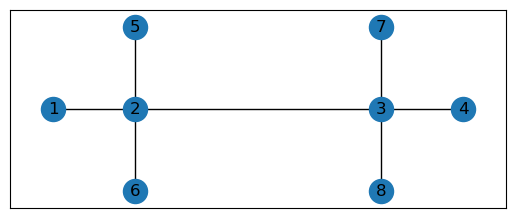

In [3]:
nx.draw_networkx(G, nx.get_node_attributes(G, 'pos'))
plt.gca().set_aspect('equal')

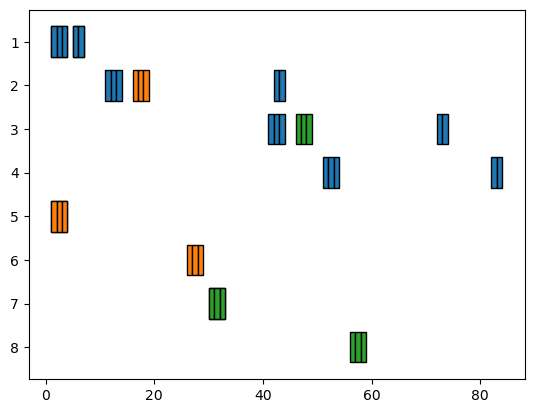

In [4]:
y = solve(instance)['y']
plot_schedule(instance, y)

Now we use the MotionSynthesize procedure to generate trajectories.

In [5]:
%cd /home/jeroen/repos/traffic-scheduling/
from motion.motion import motion_synthesize

/home/jeroen/repos/traffic-scheduling


In [6]:
# fixed parameters
params = dict(vmax=1, umax=0.3, l=1, dt=0.5)

For every vehicle, we first extract a list of "checkpoints", which are pairs of time and location corresponding with crossing the intersections/nodes on their routes.

In [7]:
route = instance['route']
release = instance['release']

N = len(release)
n = [len(r) for r in release] # number of arrivals per class
nodes = instance['G'].nodes

trajectories = [[] for l in range(N)]

for l in range(N):
    for k in range(n[l]):
        # first checkpoint is just (release time, first node on route)
        v_prev = route[l][0] # previous node
        pos_cum = 0 # cumulative position
        C_t = [release[l][k]] # checkpoint times
        C_pos = [0] # checkpoint positions along route
        for v in route[l][1:]:
            t = y[l, k, v]
            pos_cum += float(np.linalg.norm(np.array(nodes[v_prev]['pos']) - np.array(nodes[v]['pos'])))
            C_t.append(t)
            C_pos.append(pos_cum)
            v_prev = v        
        prev = None
        if k > 0:
            prev = (prev_tf, trajectories[l][-1][1])
        traject = motion_synthesize(C_t, C_pos, params, prev=prev).T.values.tolist()[0]
        trajectories[l].append((C_t[0], traject))
        prev_tf = C_t[-1] # final time of previous trajectory

SCIP 9.0.1: WARNING: No dual information available when presolving was performed.
SCIP 9.0.1: optimal solution; objective 2525
0 simplex iterations
SCIP 9.0.1: WARNING: No dual information available when presolving was performed.
SCIP 9.0.1: optimal solution; objective 2525
0 simplex iterations
SCIP 9.0.1: WARNING: No dual information available when presolving was performed.
SCIP 9.0.1: optimal solution; objective 2525
0 simplex iterations
SCIP 9.0.1: WARNING: No dual information available when presolving was performed.
SCIP 9.0.1: optimal solution; objective 2988.050039
44853 simplex iterations
 
------------ WARNINGS ------------
  Type                         MaxAbs [Name]   MaxRel [Name]
* quadratic con(s)             -               -             
*: Using the solver's aux variable values.
Documentation: mp.ampl.com/modeling-tools.html#automatic-solution-check.
SCIP 9.0.1: WARNING: No dual information available when presolving was performed.
SCIP 9.0.1: optimal solution; objective

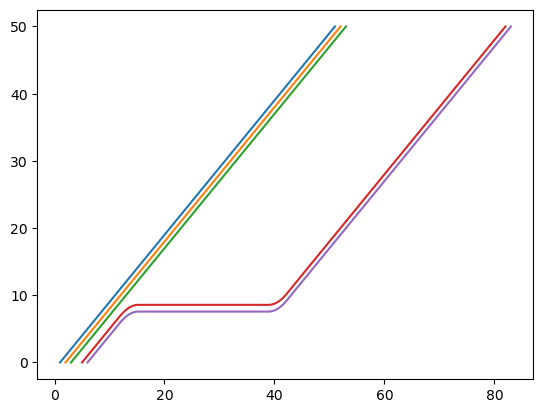

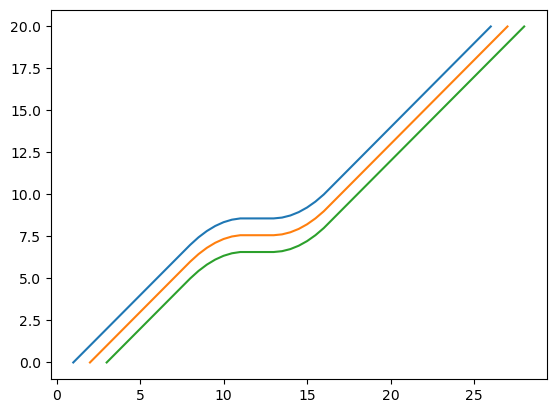

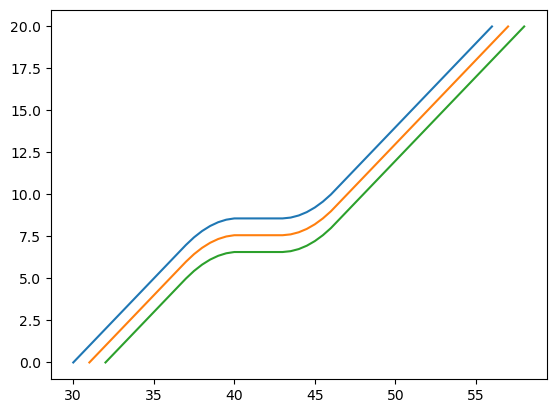

In [8]:
for l in range(N):
    for k in range(n[l]):
        t0 = trajectories[l][k][0]
        ts = len(trajectories[l][k][1])
        t = np.arange(t0, t0 + ts*params['dt'], params['dt'])
        plt.plot(t, trajectories[l][k][1])
    plt.show()

In [9]:
from motion.animation import animate
plt.rcParams["animation.html"] = "jshtml"
plt.ioff();

In [10]:
animate(instance, trajectories, params['dt'], vehicle_l=params['l'])